# Fourier spectrum of quantum models - Coefficients and frequencies

500 points

In this problem, we will extract the Fourier coefficients and frequencies of a particular quantum model using PennyLane's Fourier Module. The quantum model, which uses **four qubits** is the following:

<img src=" 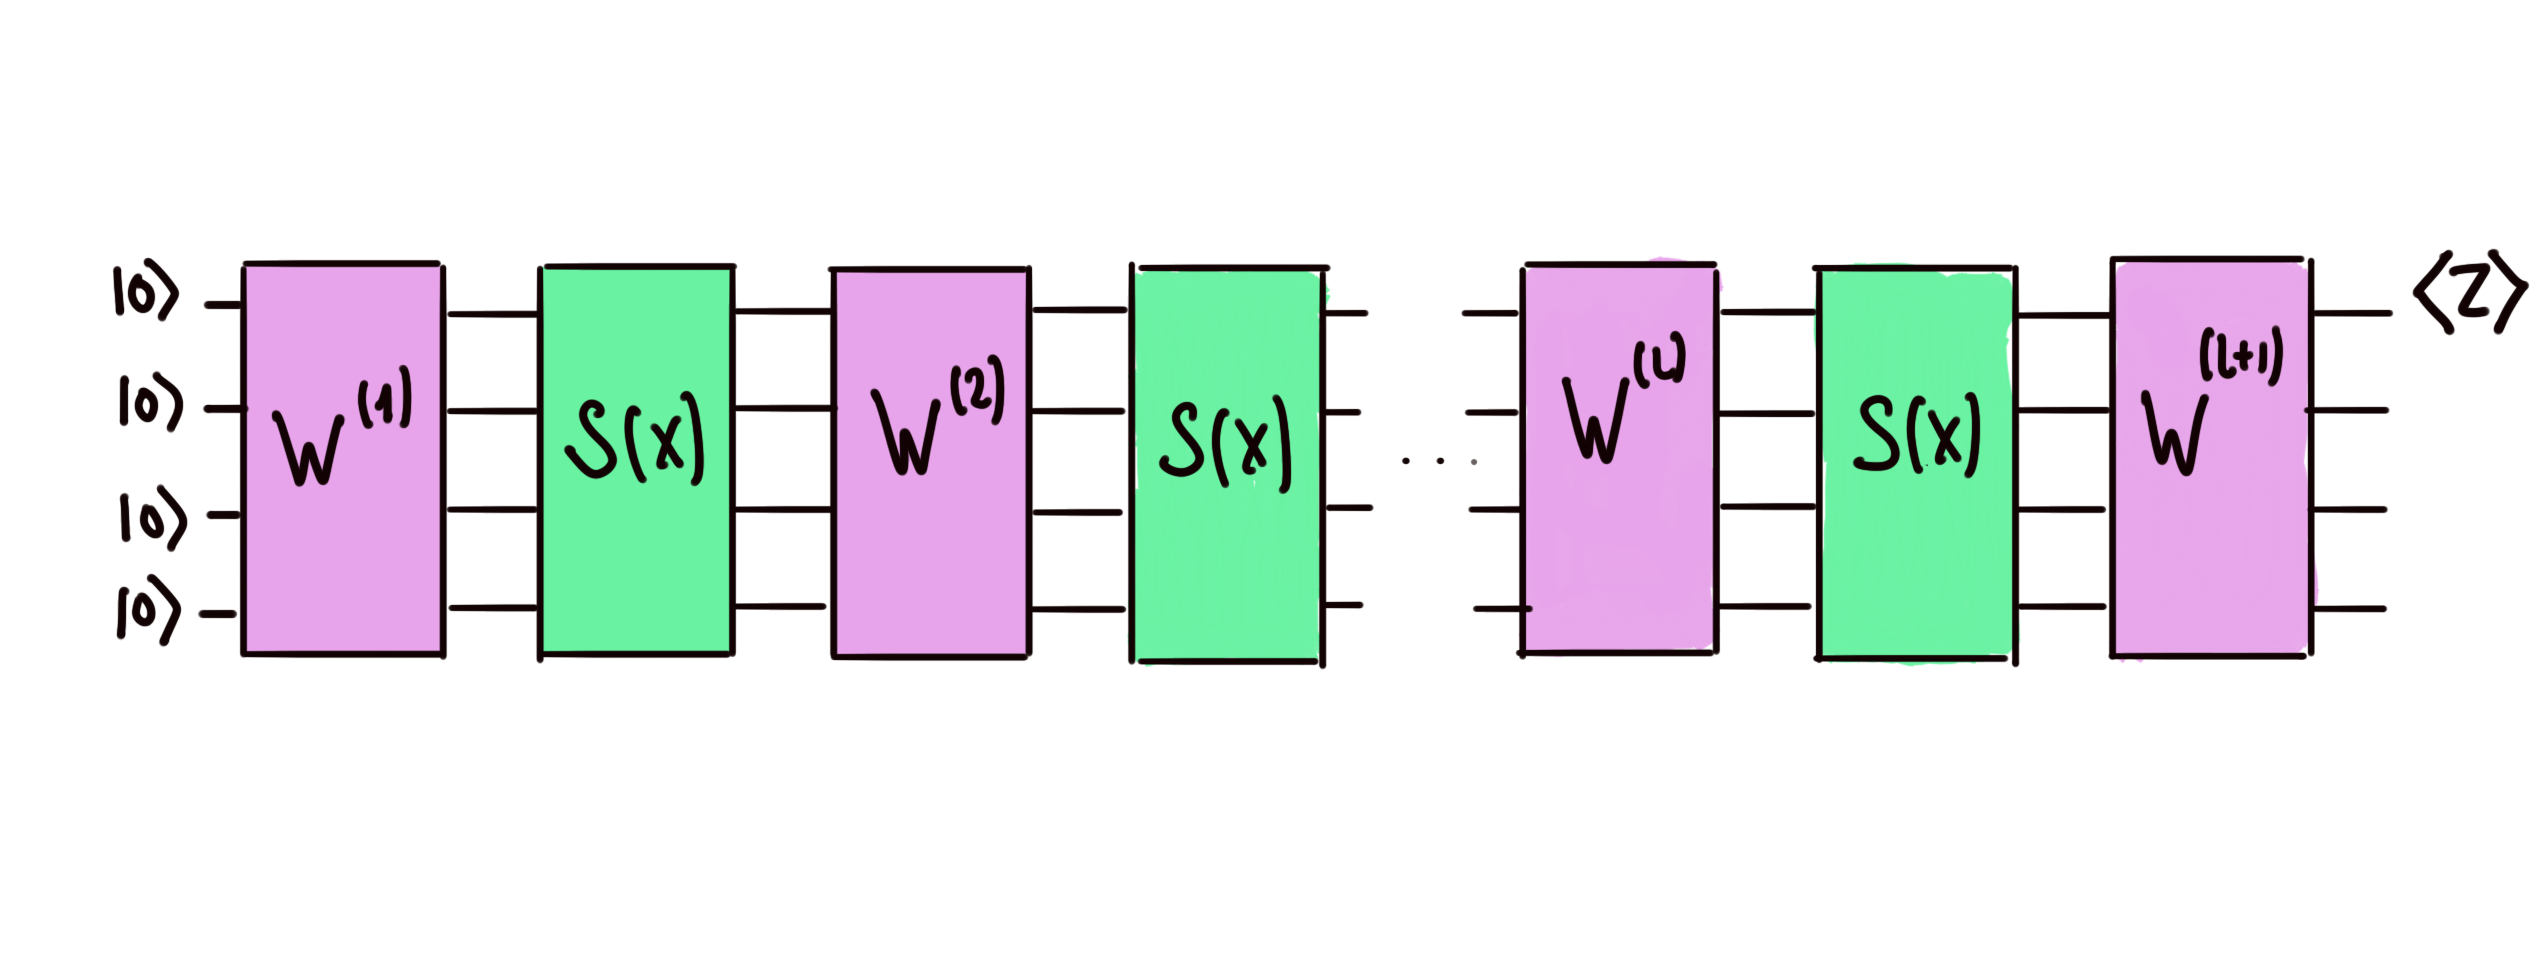">


Note that the output is the expectation value of the Pauli-Z observable on the first wire.

The trainable circuit blocks $W^{(i)}$ correspond to a number of *Basic Entangler Layers*:

<img src=" 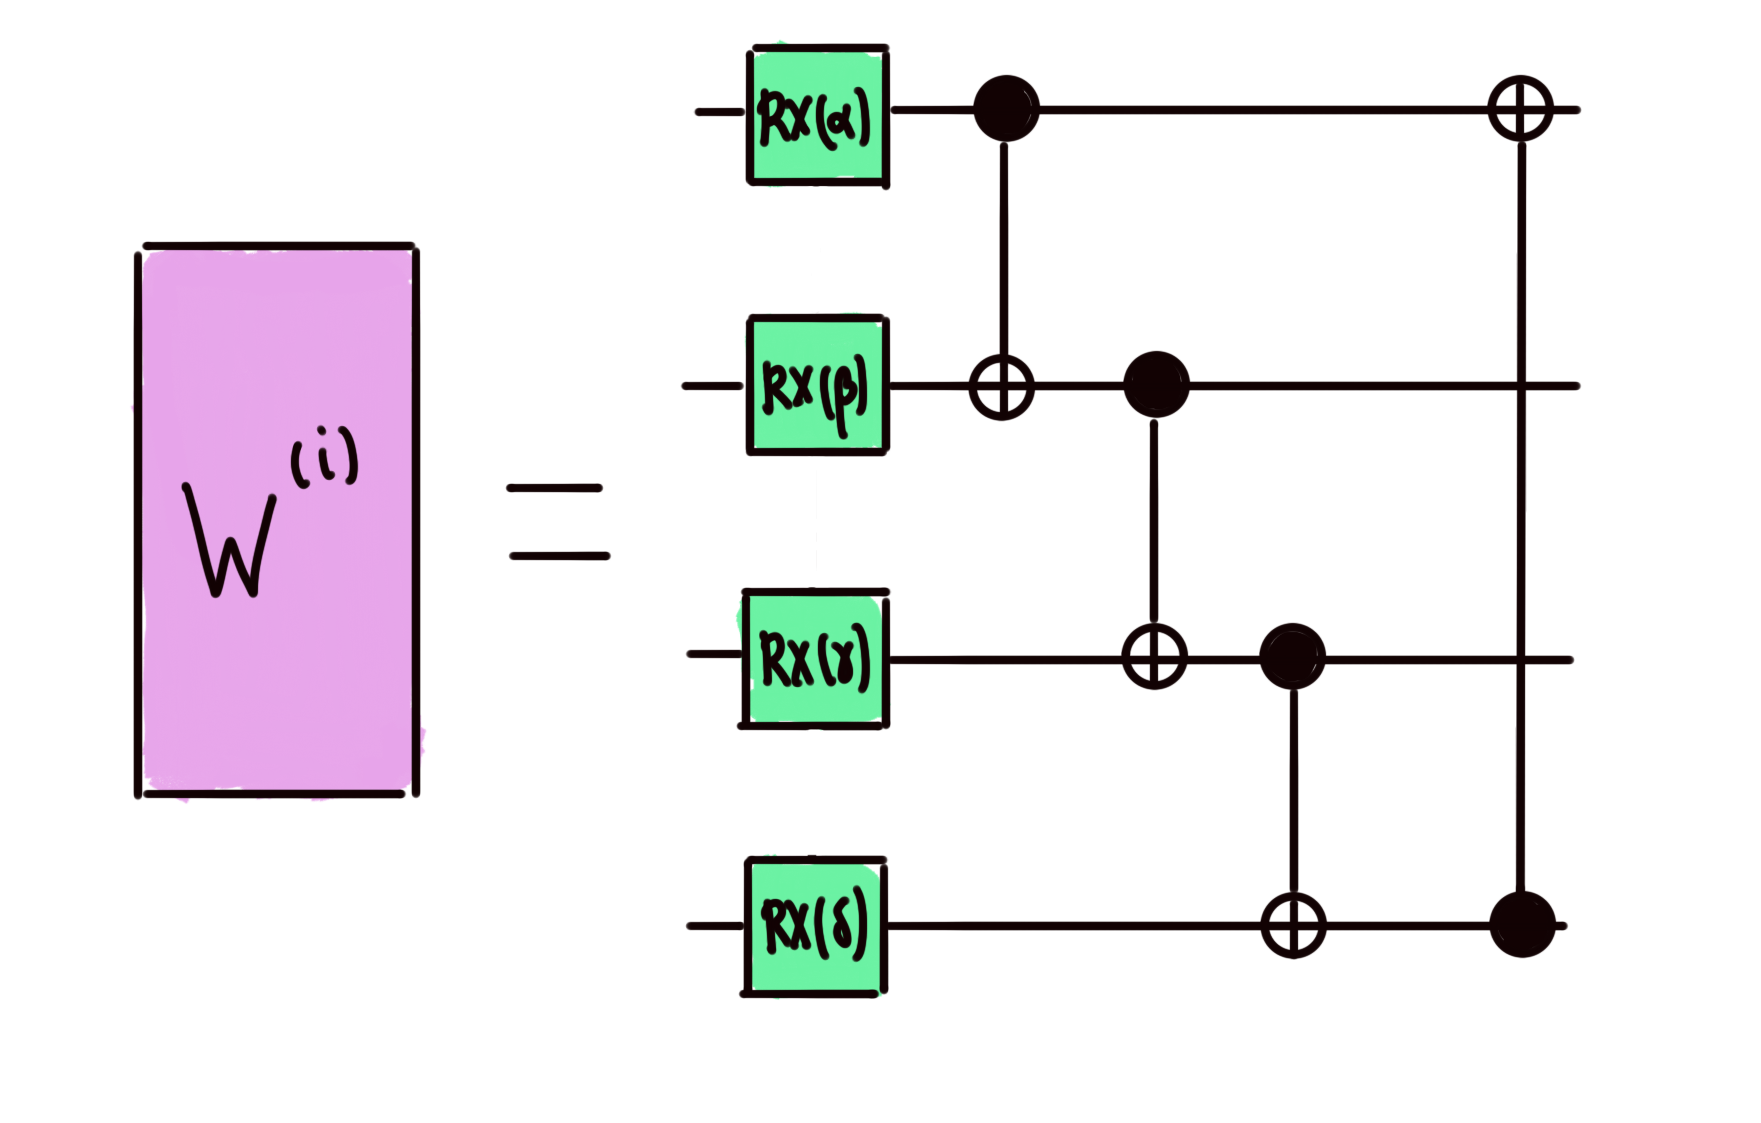">

This number of entangler layers need not be the same in every block! Each
$W^{(i)}$
could be a concatenation of a different number of these.

The *encoding circuit* blocks $S$
depend on the input data $x$
and we will take them to be a set of four parallel $RX$
gates (one in each wire), whose parameters are all the input data $x$.

<img src=" 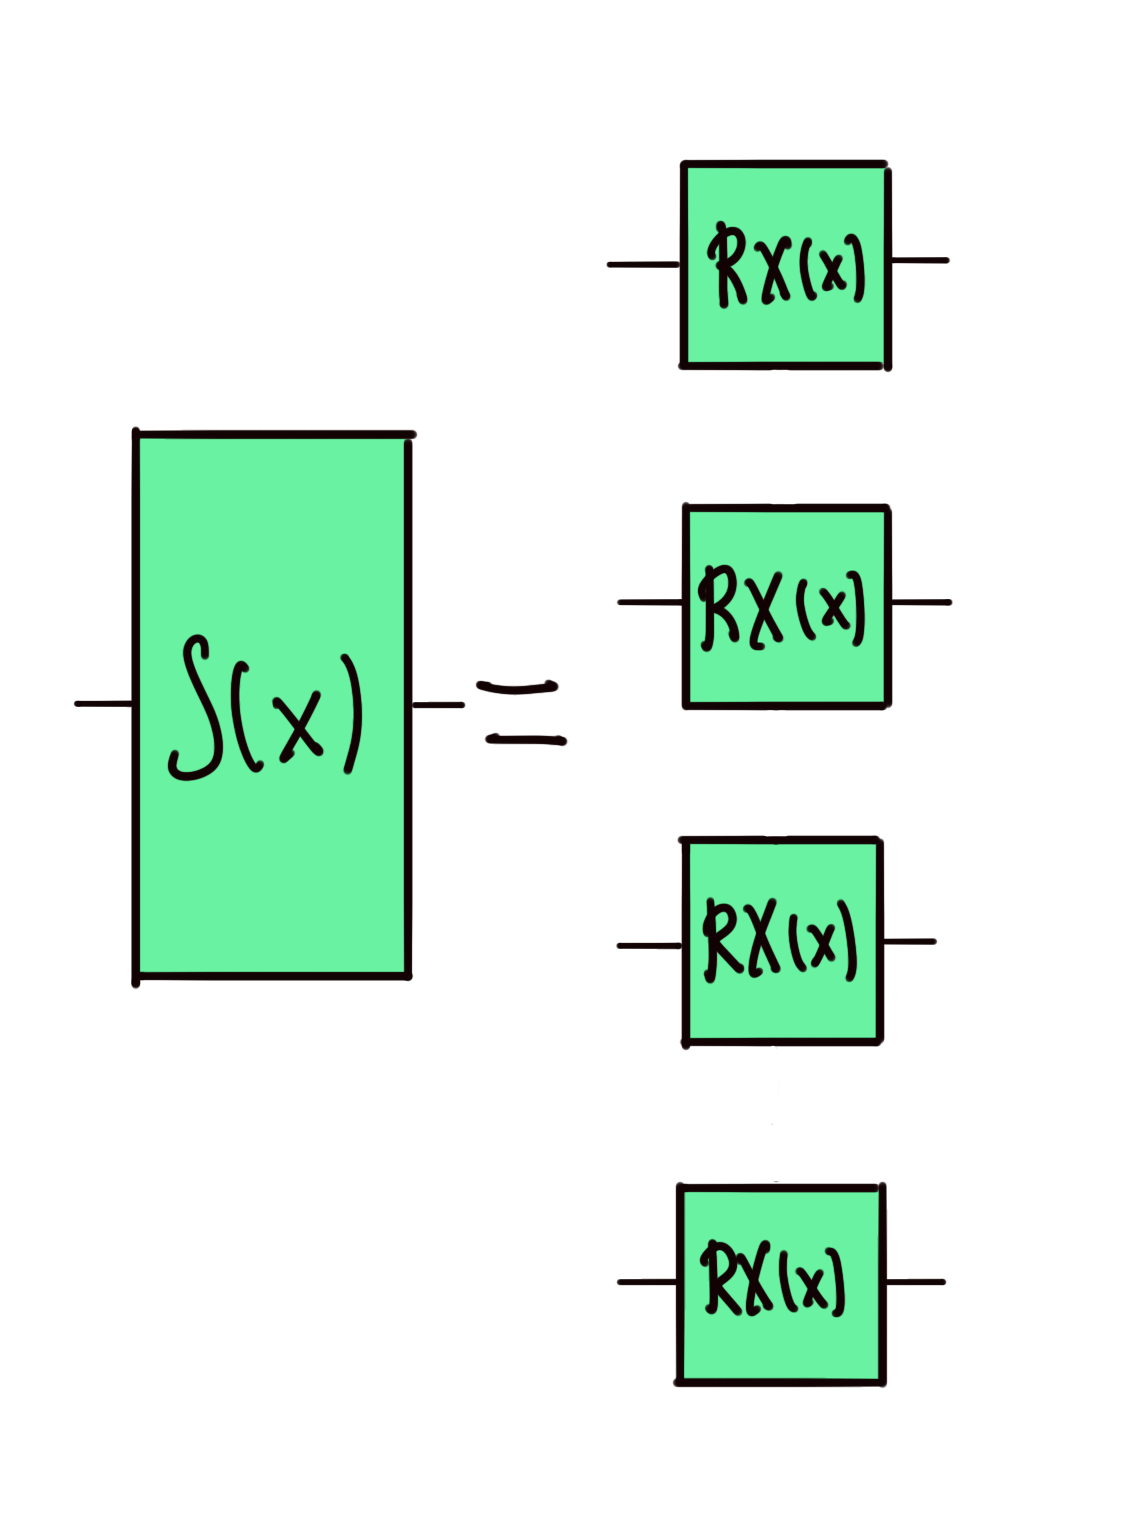">

Your task is to find the Fourier frequencies allowed by this quantum model and the Fourier coefficients associated to each of these frequencies. Be mindful that these quantities do not depend on the input data!

## Challenge code

You must complete the `fourier_decomp` function to return a list with the Fourier frequencies and the real and imaginary parts of the Fourier coefficient associated with these frequencies.

The input `layers_params` of `fourier_decomp` specifies how many trainable circuit blocks we have in our circuit, how many basic entangler layers each block contains, and what are the parameters in the rotation within the entangler layers. The elements of the list `layers_params` are lists of lists of real numbers. The $i$-th element of `layers_params` corresponds to the $i$-th trainable circuit block. If this element is of length $j$ (i.e. it contains $j$ lists of numbers), it means that the $i$-th trainable circuit block contains $j$ basic entangler layers. Each of these $j$ lists of numbers contains 4 real numbers, corresponding to the parameters in the `RX` gates within the entangler layers.

For example, `layers_params = [[[0.1,0.3,0.4,0.5],[1.0,0.6,0.7,0.8]],[1.3,1.5,0.8,0.9]]]` gives us the circuit:

<img src=" 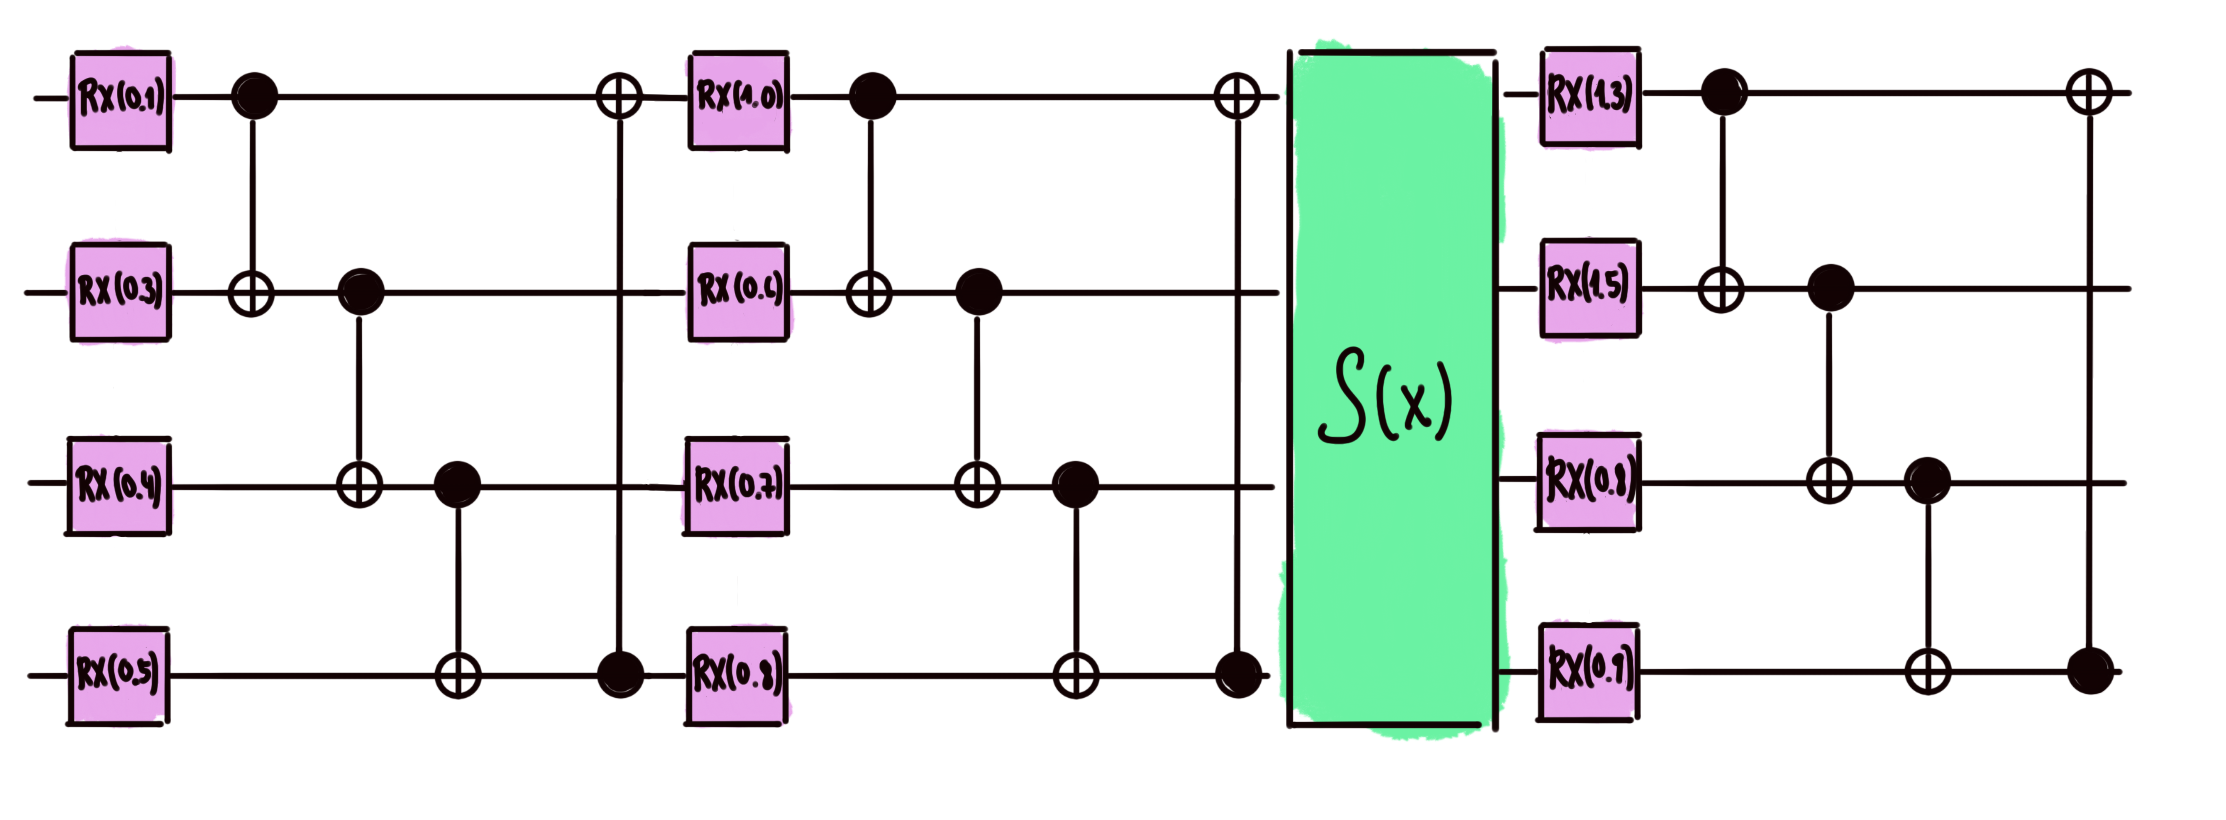">

Check the [documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasicEntanglerLayers.html) of `qml.BasicEntanglerLayers` to see how this seemingly confusing way to encode the trainable parameters actually makes your life easier!

## Input

As input to this problem, you are given `layers_params (list(list(list(float)))`, which is explained above.

## Output

This code will output a `list(list(float))`. Each element of the list is a list containing the frequency, the real value of the coefficient associated with that frequency, and the imaginary value of the coefficient, in that order. For example, the output will look like `[[freq1, real1, imag1], [freq2, real2, imag2], [freq3, real3, imag3]]`.

Frequencies must be ordered from most negative to most positive. Do keep in mind that the ordering of the Fourier coefficients when using the [Fourier module's](https://docs.pennylane.ai/en/stable/code/qml_fourier.html) `qml.fourier.coefficients` is, for example,
$[c_0,c_1,c_2,c_3,c_4,c_{-4},c_{-3},c_{-2},c_{-1}]$
(for 4 frequencies, but there may be more), where the subscripts represent the frequencies, so you may have some reordering to do!

If your solution matches the correct one within the given tolerance specified in check (in this case it's a `0.01` absolute tolerance), the output will be `"Correct!"`. Otherwise, you will receive a `"Wrong answer"` prompt.

Good luck!


In [1]:
import functools
import json
import pennylane as qml
import pennylane.numpy as np

In [2]:
def fourier_decomp(layers_params):
    """
    Returns the frequencies and coefficient of our quantum model, specified by layers_params

    Args:
    layers_params: list(list(list(float))). Specifies the number of basic entangling layers and their
    parameters as explained in the statement of the problem.

    Returns: list([float,float,float]). A list three-element list. The first element of each list is the frequency. The second
    element is the real part of the coefficient associated with that frequency in the Fourier decomposition. The third element
    is the imaginary part of such coefficient.
    """
    print("INPUT", layers_params)
    dev = qml.device("default.qubit", wires=4)

    def entl(params):
        for wire in [0,1,2,3]:
            qml.RX(params[wire], wires = wire)

        qml.CNOT(wires = [0,1])
        qml.CNOT(wires = [1,2])
        qml.CNOT(wires = [2,3])
        qml.CNOT(wires = [3,0])


    @qml.qnode(dev)
    def circuit(layers_params, x):
        """
        This function is the quantum circuit made of alternating entangling layers and rotations representing our quantum model
        """
        
        last_idx = len(layers_params) - 1

        for idx, ii in enumerate(layers_params):
            for jj in ii:
                #qml.BasicEntanglerLayers([jj], rotation=qml.RX, wires = range(4))
                entl(jj)

            if( (idx != last_idx) or (idx==0) ):
                for wire in [0,1,2,3]:
                    qml.RX(x, wires = wire)

        return qml.expval(qml.PauliZ(0))

    
    corr = 4
    partial_circuit = functools.partial(circuit, layers_params)
    
    coeffs = qml.fourier.coefficients(partial_circuit, 1, corr, lowpass_filter=True)
    
    reordered = []
    # do -4, ..., -1
    for ch, pe in zip(list( range(-corr,0) ), list( range(corr+1,2*corr+1) )):
        try:
            reordered.append([float(ch), float(np.real(coeffs)[pe].unwrap()), float(np.imag(coeffs)[pe].unwrap())])
        except:
            reordered.append([float(ch), 0.0, 0.0])
    
    # do 0, 1, ..., 4
    for ch in list( range(0,corr+1) ):
        try:
            reordered.append([float(ch), float(np.real(coeffs)[ch].unwrap()), float(np.imag(coeffs)[ch].unwrap())])
        except:
            reordered.append([float(ch), 0.0, 0.0])
    return reordered

In [3]:
# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:

    ins = json.loads(test_case_input)
    output = fourier_decomp(ins)

    return str(output)

def check(solution_output: str, expected_output: str) -> None:
    """
    Compare solution with expected.

    Args:
            solution_output: The output from an evaluated solution. Will be
            the same type as returned.
            expected_output: The correct result for the test case.

    Raises:
            ``AssertionError`` if the solution output is incorrect in any way.
    """

    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-2
    ), "Your calculated Fourier spectrum isn't quite right."


In [4]:
test_cases = [['[[[2,2,2,2],[1,2,1,1]],[[3,4,5,6]]]', '[[-4.0, -2.4671622769447922e-17, -1.2335811384723961e-17], [-3.0, -0.03395647263976357, 0.010208410500915437], [-2.0, 2.8360500437920326e-17, 1.850371707708594e-17], [-1.0, 0.11762992558035439, -0.13619443127813127], [0.0, 8.018277400070575e-17, 0.0], [1.0, 0.11762992558035439, 0.13619443127813124], [2.0, 3.700743415417188e-17, -1.850371707708594e-17], [3.0, -0.03395647263976357, -0.010208410500915437],[4.0, -3.688877668472405e-18, 1.850371707708594e-17]]'], ['[[[2,2,2,2]],[[3,4,5,6]]]', '[[-4.0, 1.2335811384723961e-17, 3.700743415417188e-17],  [-3.0, 0.022482345076620468, -0.07855141721016852], [-2.0, -1.2335811384723961e-17, -6.536793459209221e-17], [-1.0, -0.13243693333822854, 0.17097830099559677], [0.0, -2.4671622769447922e-17, 0.0], [1.0, -0.13243693333822854, -0.17097830099559677], [2.0, -2.4671622769447922e-17, 7.401486830834377e-17], [3.0, 0.022482345076620468, 0.07855141721016852], [4.0, -1.2335811384723961e-17, -3.331855648569948e-17]]']]

In [5]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)
    except Exception as exc:
        print(f"Runtime Error. {exc}")
    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")
        else:
            print("Correct!")

Running test case 0 with input '[[[2,2,2,2],[1,2,1,1]],[[3,4,5,6]]]'...
INPUT [[[2, 2, 2, 2], [1, 2, 1, 1]], [[3, 4, 5, 6]]]
Correct!
Running test case 1 with input '[[[2,2,2,2]],[[3,4,5,6]]]'...
INPUT [[[2, 2, 2, 2]], [[3, 4, 5, 6]]]
Correct!
